# Read ASTRAL PSL mean meteorology files
## me2: radiometer, sea snake, pressure
## me1: ORG, 

In [1]:
# usings

using Revise
using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

# general PSL DAS readers
include("./readers.jl")
using .NoaaDas

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

permutedims (generic function with 13 methods)

In [3]:
mastdir = "./data/PSL/"

# keys for me1 format
me1keys = Symbol.(split("""time
    Batt_Volt
    PTemp
    ORG_Car_v
    ORG_Sig_v
    ORG_mmhr
    airflow
    No_data
    No_data
    Tair
    RH
    Std_Dev_airflow"""))

# keys for me2 format
me2keys = Symbol.(split("""time
    Batt_Volt
    PTemp
    Case1_R
    Case1_T
    Dome1_R
    Dome1_T
    Case2_R
    Case2_T
    Dome2_R
    Dome2_T
    PIR1_V
    PIR1_wm2
    PSP1_V
    PSP1_wm2
    PIR2_V
    PIR2_wm2
    PSP2_V
    PSP2_wm2
    Snake_R
    Snake_C
    BP_hpa"""))

22-element Vector{Symbol}:
 :time
 :Batt_Volt
 :PTemp
 :Case1_R
 :Case1_T
 :Dome1_R
 :Dome1_T
 :Case2_R
 :Case2_T
 :Dome2_R
 :Dome2_T
 :PIR1_V
 :PIR1_wm2
 :PSP1_V
 :PSP1_wm2
 :PIR2_V
 :PIR2_wm2
 :PSP2_V
 :PSP2_wm2
 :Snake_R
 :Snake_C
 :BP_hpa

In [4]:
# read and plot an example day

#=
prefix = "me2"
dt = Date(2024,5,8) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# get_das_pathfiles(prefix, dt)
pathfilenames = get_das_pathfiles(prefix, dt)[7]
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
Me2day = read_das_dict(get_das_pathfiles("me2", dt), me2keys; ncolumn=21)
Me1day = read_das_dict(get_das_pathfiles("me1", dt), me1keys; ncolumn=11)
delete!(Me1day, :No_data) # delete blank column(s) from Dict
=#

In [5]:
# plot Me2 variables

"loads and plots me2 variable group: radiometers, temperature, pressure"
function plot_me2(yd)
    dt = Date(2023,12,31) + Day(yd)
    Me2day = read_das_dict(get_das_pathfiles("me2", dt), me2keys; ncolumn=21)
    dtf = Dates.format(Me2day[:time][5], dateformat"yyyy-mm-dd")
    dh = decimal_hour.(Me2day[:time])
    
    # Me2 variable groups
    Vkey = filter(x -> endswith(String(x), "_V")    , me2keys)
    Tkey = filter(x -> endswith(String(x), r"_T|_C"), me2keys)
    Wkey = filter(x -> endswith(String(x), "_wm2"  ), me2keys)
    
    dh = decimal_hour.(Me2day[:time])
    
    # quick plot 1 day
    clf()
    subplot(2,2,1)
    for k in Tkey[1:4]
        plot(m2n.(dh), m2n.(Me2day[k]), label=String(k))
    end
    legend()
    title("radiometer temperatures")
    
    subplot(2,2,2)
    for k in Tkey[5:end]
        plot(m2n.(dh), m2n.(Me2day[k]), label=String(k))
    end
    plot(m2n.(dh), m2n.(Me2day[:PTemp]), label="PTemp")
    legend()
    title("snake and PT temperature")
    
    subplot(2,2,3)
    for k in Wkey
        plot(m2n.(dh), m2n.(Me2day[k]))
    end
    title("W/m2")
    legend((String.(Wkey)))
    
    subplot(2,2,4)
    plot(m2n.(dh), m2n.(Me2day[:BP_hpa]))
    title("pressure")
    
    # legend("BP_hpa")
    # subplot(2,2,4)
    # for k in Vkey
    #     plot(m2n.(dh), m2n.(Me2day[k]))
    # end
    # title("voltage")
    # legend((String.(Vkey)))
    
    tight_layout()
    return dtf
end

"loads data and makes a daily png plot of rain, T, RH"
function plot_trh_org(yd)
    dt = Date(2023,12,31) + Day(yd)
    Me1day = read_das_dict(get_das_pathfiles("me1", dt), me1keys; ncolumn=11)
    dtf = Dates.format(Me1day[:time][5], dateformat"yyyy-mm-dd")
    dh = decimal_hour.(Me1day[:time])
    
    clf()
    subplot(3,1,1)
    plot(dh, m2n.(Me1day[:ORG_mmhr]))
    ylabel("rain (mm/h)")
    title(dtf)

    subplot(3,1,2)
    plot(dh, m2n.(Me1day[:Tair]))
    ylabel("Tair (C)")

    subplot(3,1,3)
    plot(dh, m2n.(Me1day[:RH]))
    ylabel("RH (%)")
    xlabel("hour")

    tight_layout()
    return dtf
end

plot_trh_org

missing_days = Any[149, 150]


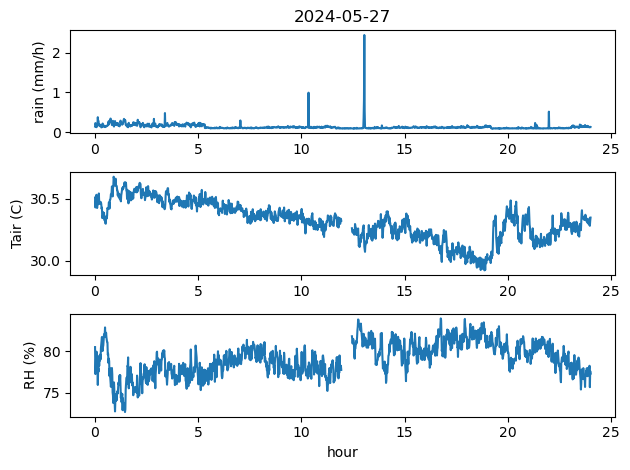

2-element Vector{Any}:
 149
 150

In [6]:
# quick plot daily me2, me1 data
missing_days = []
for yd in 149:165
    if isdir(joinpath(mastdir,"$yd"))
        dtf = plot_me2(yd)
        savefig(joinpath(mastdir,"plot","T_radmr_$(yd)_$dtf.png"))

        plot_trh_org(yd)
        savefig(joinpath(mastdir,"plot","trh_org_$(yd)_$dtf.png"))
    else
        push!(missing_days, yd)
    end
end
@show missing_days